In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

In [2]:
import os
USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '3' if USE_GPU else ''
EPS = 1e-15

In [3]:
lpmt_hits = pd.read_hdf('./juno/phase_3/lpmt_hits.h5', mode='r') 
spmt_hits = pd.read_hdf('./juno/phase_3/spmt_hits.h5', mode='r')
pmts_pos = pd.read_csv('./juno/pmts_pos.csv') 
true_info = pd.read_csv('./juno/phase_3/true_info.csv')

In [1004]:
lpmt_hits = pd.read_hdf('./juno/lpmt_hits.h5', mode='r') 
spmt_hits = pd.read_hdf('./juno/spmt_hits.h5', mode='r')
pmts_pos = pd.read_csv('./juno/pmts_pos.csv') 
true_info = pd.read_csv('./juno//true_info.csv')

In [4]:
test_l_hits = pd.read_hdf('./juno/phase_3/test_l_hits.h5') 
test_s_hits = pd.read_hdf('./juno/phase_3/test_s_hits.h5')

In [1005]:
test_l_hits = pd.read_hdf('./juno/test_l_hits.h5') 
test_s_hits = pd.read_hdf('./juno/test_s_hits.h5')

In [5]:
train = pd.read_hdf('./juno/train_data_ph1.h5', mode='r') 
# validation = pd.read_hdf('../data/phase1/validation_data_ph1.h5', mode='r') 
test = pd.read_hdf('./juno/test_data_ph1.h5', mode='r') 
# true_info = pd.read_hdf('./juno/true_data_ph1.h5', mode='r') 

In [6]:
train.head()

,event,hitTime,pmtID,is_large,pmt_x,pmt_y,pmt_z,E,R,x,y,z
0,0,249.992615,14175,True,-5411.832,16838.455,-7471.1797,4.747791,14610.378,8290.779,11995.618,911.74286
1,0,92.820419,14175,True,-5411.832,16838.455,-7471.1797,4.747791,14610.378,8290.779,11995.618,911.74286
2,0,40.010311,17319,True,12080.419,14903.949,-758.8111,4.747791,14610.378,8290.779,11995.618,911.74286
3,0,218.473663,17319,True,12080.419,14903.949,-758.8111,4.747791,14610.378,8290.779,11995.618,911.74286
4,0,91.932716,17319,True,12080.419,14903.949,-758.8111,4.747791,14610.378,8290.779,11995.618,911.74286


In [7]:
test.head()

,event,hitTime,pmtID,is_large,pmt_x,pmt_y,pmt_z
0,16000,130.768448,3289,True,2134.6404,15017.766,11770.728
1,16002,63.246658,3289,True,2134.6404,15017.766,11770.728
2,16007,85.495117,3289,True,2134.6404,15017.766,11770.728
3,16009,126.604965,3289,True,2134.6404,15017.766,11770.728
4,16015,67.194359,3289,True,2134.6404,15017.766,11770.728


In [8]:
true_info.head()

,E,R,evtID,x,y,z
0,7.397038,15267.927,26000,13759.8120,-2082.3127,6280.2180
1,8.934670,17321.850,26001,-11983.3910,12273.5100,2409.5234
2,5.901982,17258.846,26002,-16006.6580,2820.8100,-5804.9690
3,6.396549,6628.715,26003,937.7113,2855.7812,5908.0513
4,9.518383,16806.303,26004,-9749.3150,-3329.8782,13278.3510


In [9]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


### Merging data

In [1007]:
train_df = pd.concat([lpmt_hits, spmt_hits], axis=0)
test_df = pd.concat([test_l_hits, test_s_hits], axis=0)
data = pd.concat([train_df, test_df], axis=0)
print(lpmt_hits.shape, spmt_hits.shape, train_df.shape)
print(test_l_hits.shape, test_s_hits.shape, test_df.shape)
print(data.shape)
split_idx = train_df.shape[0]

(136785467, 3) (3494869, 3) (140280336, 3)
(43049370, 3) (1099104, 3) (44148474, 3)
(184428810, 3)


In [11]:
split_idx = train_df.shape[0]

In [12]:
data.iloc[:split_idx].shape

(152816933, 4)

In [13]:
split_events = true_info.shape[0]
print(split_events)

16000


In [14]:
first_train_event_num = lpmt_hits.event.min()
first_test_event_num = test_l_hits.event.min()

In [15]:
first_test_event_num

42000

### Baseline

we're going to take mean of every real_numbered value

In [16]:
base_train = train[['event', 'hitTime', 'pmt_x', 'pmt_y', 'pmt_z']].groupby('event').mean()
base_test = test[['event', 'hitTime', 'pmt_x', 'pmt_y', 'pmt_z']].groupby('event').mean()

In [17]:
base_train.head()

,hitTime,pmt_x,pmt_y,pmt_z
event,,,,
0,95.142883,6742.747754,9929.261316,767.530051
1,98.507034,9148.488313,4254.463594,-5668.030986
2,96.424873,11465.888473,-3298.430170,215.455769
3,100.268799,-1500.403105,-11539.483607,2423.068899
4,104.633980,-7100.159824,709.128010,7903.695198


In [18]:
base_test.head()

,hitTime,pmt_x,pmt_y,pmt_z
event,,,,
16000,104.666626,-7187.699821,4022.543151,6771.929508
16001,93.139519,40.935368,-12232.407876,-28.051466
16002,124.935867,627.151867,5749.089462,4393.655642
16003,128.582108,5255.132815,2112.435941,-1009.168551
16004,106.997620,-8252.127742,6186.875231,883.975080


## Trying YuMalyshkin features

$N_{p.e.}$

meant $1_{st}$ hit time

center of hits E

center of hits Z

### Center of hits
$$
\frac{\sum_{i}^{Num\_of\_pmts}Position_{i} * hits\_per\_pmt}{Sphere\_radius * Num\_of\_pmts}
$$

In [19]:
sphere_radius = 19200

working with original data (not train/test separated)

In [20]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


In [1006]:
data.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


In [1008]:
#counting hits per pmt per event
CoH_hits = pd.DataFrame(data=data.groupby(['event','pmtID']).size(), columns=['hits']).reset_index()

#merging with pmt coordinates
CoH = CoH_hits.merge(pmts_pos.rename(columns={'pmt_id':'pmtID'}), on='pmtID', how='left')
CoH.head()

#multiplying values
CoH['X'] = CoH.hits * CoH.pmt_x
CoH['Y'] = CoH.hits * CoH.pmt_y
CoH['Z'] = CoH.hits * CoH.pmt_z

CoH_calculation = CoH.groupby('event').agg({'X' : 'sum','Y' : 'sum','Z' : 'sum', 'pmtID' : 'count'})
CoH_calculation.X /= (CoH_calculation.pmtID * sphere_radius)
CoH_calculation.Y /= (CoH_calculation.pmtID * sphere_radius)
CoH_calculation.Z /= (CoH_calculation.pmtID * sphere_radius)
CoH_calculation.rename(columns={'pmtID':'unique_pmts'}, inplace=True)
CoH_calculation.head()

# X, Y, Z are Centers of hits for each of the exes for each event

features = CoH_calculation.copy()

features['1st_hit_time'] = data.groupby(['event'])['hitTime'].min()
features['mean_hit_time'] = data.groupby('event')['hitTime'].mean() / features['1st_hit_time']
features['pmt_per_event'] = data.groupby(['event'])['pmtID'].count()

In [1009]:
features.head()

,X,Y,Z,unique_pmts,1st_hit_time,mean_hit_time,pmt_per_event
event,,,,,,,
0,0.613218,0.903015,0.069803,4794,24.005239,3.963422,8371
1,0.759930,0.353402,-0.470822,4211,23.550785,4.182749,6716
2,1.155916,-0.332526,0.021721,6011,23.950851,4.025948,11635
3,-0.144840,-1.113953,0.233909,3330,12.362344,8.110825,6172
4,-0.515799,0.051515,0.574172,3888,32.193615,3.250147,5423


In [1010]:
features.shape

(21000, 7)

In [1011]:
final_features = ['X', 'Y', 'Z', 'unique_pmts', 'mean_hit_time']

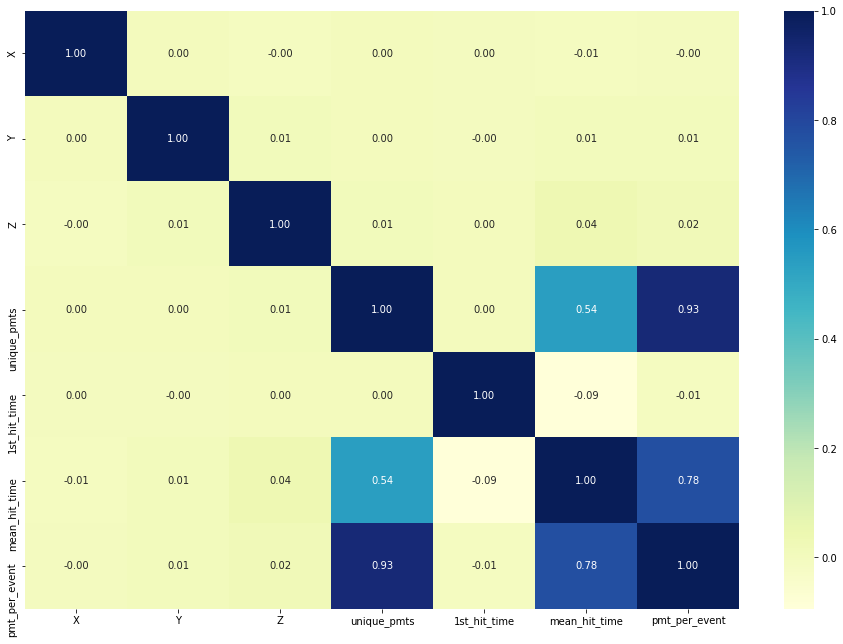

In [25]:
corr = features.corr('spearman') 
plt.figure(figsize = ( 16 , 11 )) 
sns.heatmap(corr,annot=True,fmt='.2f',cmap="YlGnBu");

In [1012]:
features = features[final_features]

In [1015]:
features.shape

(21000, 5)

In [27]:
true_info.head()

,E,R,evtID,x,y,z
0,7.397038,15267.927,26000,13759.8120,-2082.3127,6280.2180
1,8.934670,17321.850,26001,-11983.3910,12273.5100,2409.5234
2,5.901982,17258.846,26002,-16006.6580,2820.8100,-5804.9690
3,6.396549,6628.715,26003,937.7113,2855.7812,5908.0513
4,9.518383,16806.303,26004,-9749.3150,-3329.8782,13278.3510


In [60]:
features.shape

(21000, 5)

In [61]:
true_info.shape

(16000, 6)

In [62]:
split_events

16000

# CatBoost

In [383]:
X_train = features.iloc[:split_events]
X_test = features.iloc[split_events:]

In [78]:
X_test.head()

,X,Y,Z,unique_pmts,mean_hit_time
event,,,,,
42000,-0.206443,-0.833504,0.177160,3527,-1.426612
42001,-0.918808,0.709120,-0.433661,5988,-1.175502
42002,-0.107736,-0.423874,0.319924,4878,-1.521969
42003,-0.177832,-0.313203,-0.834091,4715,-1.341060
42004,0.218156,-0.029867,0.521956,2022,-1.862988


In [30]:
true_info.shape

(16000, 6)

In [59]:
base_train

,hitTime,pmt_x,pmt_y,pmt_z
event,,,,
0,95.142883,6742.747754,9929.261316,767.530051
1,98.507034,9148.488313,4254.463594,-5668.030986
2,96.424873,11465.888473,-3298.430170,215.455769
3,100.268799,-1500.403105,-11539.483607,2423.068899
4,104.633980,-7100.159824,709.128010,7903.695198
5,94.001892,3216.086416,7470.465446,8721.292460
6,94.231995,1265.835589,-9412.370616,-7289.322666
7,103.424362,-1543.976834,6765.496230,9148.270622
8,125.090721,3924.965117,-1605.223731,-5210.235467


In [31]:
from catboost import Pool, CatBoostRegressor

### baseline

In [32]:
baseline_train_pool_E = Pool(base_train.values, 
                  true_info["E"].values)
baseline_train_pool_R = Pool(base_train.values, 
                  true_info["R"].values)

In [33]:
baseline_model_E = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(baseline_train_pool_E, verbose=False)
baseline_model_R = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(baseline_train_pool_R, verbose=False)

In [35]:
print('E',baseline_model_E.score(baseline_train_pool_E))
print('R',baseline_model_E.score(baseline_train_pool_R))

E 2.8585610577072047
R 13708.851672438332
CPU times: user 1min 14s, sys: 3.04 s, total: 1min 17s
Wall time: 3.52 s


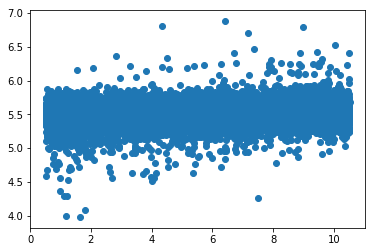

In [36]:
plt.scatter(true_info['E'].values, baseline_model_E.predict(baseline_train_pool_E))

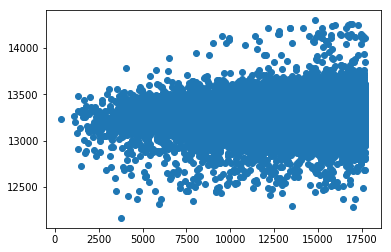

In [37]:
plt.scatter(true_info['R'].values, baseline_model_R.predict(baseline_train_pool_R))

### Model with new features

In [38]:
train_pool_E = Pool(X_train.values, 
                  true_info["E"].values)
train_pool_R = Pool(X_train.values, 
                  true_info["R"].values)

In [39]:
%%time
model_E = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(train_pool_E, verbose=False)
model_R = CatBoostRegressor(iterations=300, 
                          depth=3, 
                          learning_rate=0.1, 
                          loss_function='RMSE').fit(train_pool_R, verbose=False)

CPU times: user 1min 11s, sys: 3.01 s, total: 1min 14s
Wall time: 3.3 s


In [ ]:
%%time
baseline_model_E.fit(baseline_train_pool_E, verbose=False)
print('E',baseline_model_E.score(baseline_train_pool_E))


baseline_model_R.fit(baseline_train_pool_R, verbose=False)
print('R',baseline_model_E.score(baseline_train_pool_R))

In [45]:
print('E', model_E.score(train_pool_E))
print('R', model_R.score(train_pool_R))

E 0.4949287868152263
R 722.0733231787132


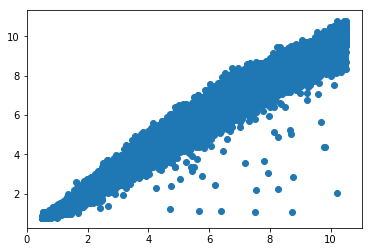

In [41]:
plt.scatter(true_info['E'].values, model_E.predict(train_pool_E) )

In [1343]:
model_E.predict(X_test)

array([6.54782103, 4.83202004, 9.67495241, ..., 5.24271781, 6.4276404 ,
       5.16112344])

In [1338]:
x_test

NameError: name 'x_test' is not defined

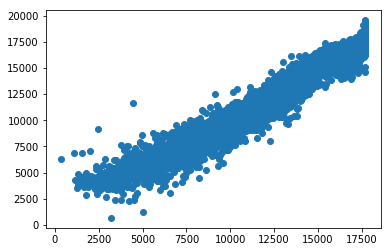

In [43]:
plt.scatter(true_info['R'].values, model_R.predict(train_pool_R) )

In [44]:
total_score = model_R.score(train_pool_R)**2 /100000 + model_E.score(train_pool_E)**2 *100
print(total_score)

29.70934924230267


### R2

In [46]:
from sklearn.metrics import r2_score

In [55]:
# baseline
print('E:',r2_score(true_info["E"].values, baseline_model_E.predict(baseline_train_pool_E)))
print('R:', r2_score(true_info["R"].values, baseline_model_R.predict(baseline_train_pool_R)))

E: 0.013358286713127332
R: 0.012112472081515446


In [50]:
# model
print('E:',r2_score(true_info["E"].values, model_E.predict(train_pool_E)))
print('R:', r2_score(true_info["R"].values, model_R.predict(train_pool_R)))

E: 0.9704232836768077
R: 0.9554926451527069


In [321]:
test_df.head()

,event,hitTime,pmtID
0,42000,147.795425,8148
1,42000,69.408455,6882
2,42000,32.437996,7980
3,42000,156.244049,3259
4,42000,30.082300,6061


In [322]:
test_pool_E = Pool(X_test.values)

In [323]:
test_pool_R = Pool(X_test.values)

In [324]:
test_pred_E = model_E.predict(test_pool_E)
test_pred_R = model_R.predict(test_pool_R)

In [232]:
X_test.head()

,X,Y,Z,unique_pmts,mean_hit_time
evtID,,,,,
16000,-0.538896,0.301589,0.507724,4125,3.349956
16001,0.004258,-1.272360,-0.002918,5858,4.469581
16002,0.038645,0.354262,0.270740,3435,2.327208
16003,0.366788,0.147440,-0.070436,6813,2.070033
16004,-0.861649,0.646005,0.092301,8375,3.070578


In [246]:
lpmt_hits.head()

,event,hitTime,isDN,pmtID
0,26000,98.512581,False,16182
1,26000,29.833193,False,4895
2,26000,44.804276,False,8485
3,26000,158.137482,False,10898
4,26000,315.410309,False,16568


In [263]:
solution = pd.DataFrame({'R':test_pred_R,'E':test_pred_E}, index=test_l_hits.event.unique())
solution.index.names = ['evtID']
solution.head()

,R,E
evtID,,
42000,13359.792436,5.455857
42001,12842.437275,5.322416
42002,13271.597981,5.665275
42003,13416.157125,5.571443
42004,13116.816491,5.450637


In [264]:
solution.to_csv('solution.csv')

## Torch NN

4 layers with 100 neurons each

4 inputs: 
- $N_{p.e.}$(LPMT)
- mean $1^{st}$ hit time
- center-of-hits R-component
- center-of-hits Z-component

2 outputs:
- E
- R

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [452]:
def get_integral_features(lpmt_hits, spmt_hits, pos, time=None):
    """
    Calculate and returns features: meanX, meanY, meanZ, R, meanTime, number of hits in event
    """
    merged_hits = pd.merge(lpmt_hits, pos, left_on='pmtID', right_on='pmt_id')
    
    means = merged_hits.groupby('event').mean()
    cohX = means['pmt_x']
    cohY = means['pmt_y']
    cohZ = means['pmt_z']
    
    if time == 'min':
        mins = merged_hits.groupby(['event', 'pmt_id']).min()['hitTime']
        cohT = mins.groupby('event').mean()
    else:
        cohT = means['hitTime']
    count = merged_hits.groupby('event')['hitTime'].count()
        
    approxR = np.sqrt(cohX**2 + cohY**2 + cohZ**2)
    
    return pd.DataFrame({'cohX':cohX.values, 
                         'cohY':cohY.values, 
                         'cohZ':cohZ.values, 
                         'cohT': cohT.values, 
                         'approxR': approxR.values,
                         'lpmtcount': count.values})

In [454]:
train_integral = get_integral_features(lpmt_hits, spmt_hits, pmts_pos)

In [455]:
train_integral.shape

(16000, 6)

In [1013]:
X = features.iloc[:split_events]
# X = train_integral
y = pd.DataFrame({'E':true_info["E"].values, 'R':true_info["R"].values})
Test_x = features.iloc[split_events:]

In [1014]:
Train_x.shape, Train_y.shape, Test_x.shape

((16000, 5), (16000, 2), (5000, 5))

In [769]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [770]:
torch.__version__

'1.0.1.post2'

In [771]:
base_train.shape

(16000, 4)

In [1341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [936]:
y.shape

(16000, 2)

In [1392]:
def run_network(X, y, predict_E=True, predict_R=True, random_state=42, num_epochs=200, verbose=False):
    to_scale=False
    X_data = X.copy()
    y_data = y.copy()
    if predict_E and predict_R:
        to_scale=True
    elif predict_E:
        y_data = y_data[['E']]
    elif predict_R:
        y_data = y_data[['R']]
        to_scale=True
        
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
    
    X_train_tensor = torch.from_numpy(X_train.values).type('torch.FloatTensor')
    X_val_tensor = torch.from_numpy(X_val.values).type('torch.FloatTensor')
    X_test_tensor = torch.from_numpy(X_test.values).type('torch.FloatTensor')
    
    
    scaler = StandardScaler()
    if to_scale:
        y_train_tensor = torch.from_numpy(scaler.fit_transform(y_train)).type('torch.FloatTensor')
        y_val_tensor = torch.from_numpy(scaler.transform(y_val)).type('torch.FloatTensor')
        y_test_tensor = torch.from_numpy(scaler.transform(y_test)).type('torch.FloatTensor')
    else:
        y_train_tensor = torch.from_numpy(y_train.values).type('torch.FloatTensor')
        y_val_tensor = torch.from_numpy(y_val.values).type('torch.FloatTensor')
        y_test_tensor = torch.from_numpy(y_test.values).type('torch.FloatTensor')
        
    n_in, n_h, n_out = X_train.shape[1], 100, y_train.shape[1]
    
    
    
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)

    # Create a model
    model = nn.Sequential(nn.Linear(n_in, n_h),
                         nn.ReLU(),
                         nn.Linear(n_h, n_h),
                         nn.ReLU(),
                         nn.Linear(n_h, n_h),
                         nn.ReLU(),
                         nn.Linear(n_h, n_h),
                         nn.ReLU(),
                         nn.Linear(n_h, n_h),
                         nn.ReLU(),
                         nn.Linear(n_h, int(n_h/2)),
                         nn.Linear(int(n_h/2), n_out),
                         )
    if verbose:
        print(model)


    model.apply(init_weights)


    compute_loss = torch.nn.MSELoss()
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        y_pred = model(X_train_tensor)
        loss = compute_loss(y_train_tensor, y_pred)
        if verbose:
            print(epoch, loss.item())   
        
#         if loss.item() < 1.3:
#             break

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

        if epoch % 3 == 0:
            y_pred = model(X_val_tensor)
            loss_val = compute_loss(y_val_tensor, y_pred)
            val_loss.append(loss_val.cpu().data.numpy())
            
    return model, X_test_tensor, y_test_tensor, y_test, scaler

Loss: 38.153026647735466
R2: -173.62842566556728


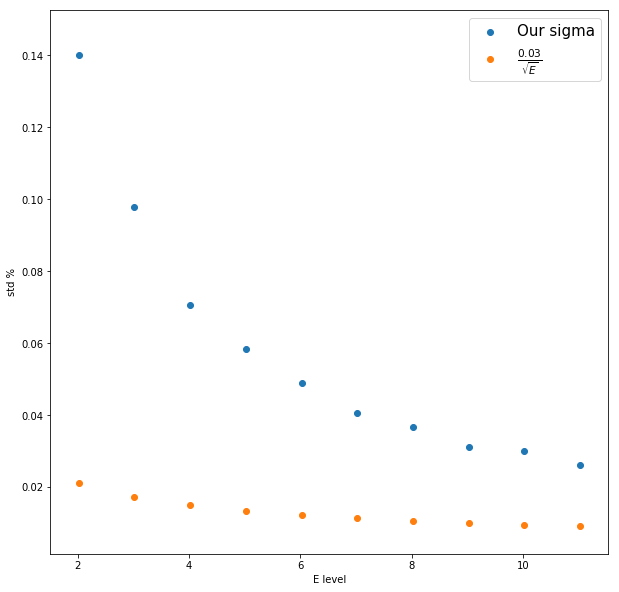

In [1331]:
model, X_test_tensor, y_test_tensor, t_test, scaler = run_network(X,y, predict_E=True, predict_R=False, num_epochs=50)

prediction = model(X_test_tensor)
prediction_df = pd.DataFrame(prediction.detach().numpy())
print('Loss:', np.sqrt(compute_loss(y_test_tensor, prediction).item()))
print('R2:',r2_score(y_test_tensor.detach().numpy(), prediction_df.values))
# print(scaler.mean_)
# real_prediction_df = scaler.inverse_transform(prediction_df)
# print('Real error:',mean_squared_error(y_test.iloc[:,0], real_prediction_df.iloc[:,0]))
# print(mean_squared_error(y_test.iloc[:,1], real_prediction_df.iloc[:,1]))

test_sigmas(model)

In [1408]:
model, X_test_tensor, y_test_tensor, tmp_y_test, scaler = run_network(X,y, predict_E=False, predict_R=True, num_epochs=200, verbose = True)

prediction = model(X_test_tensor)
prediction_df = pd.DataFrame(prediction.detach().numpy())

pred_unscaled = scaler.inverse_transform(prediction_df.values)

print('Loss:', np.sqrt(mean_squared_error(tmp_y_test.values, pred_unscaled)))
print('R2:',r2_score(tmp_y_test.values, pred_unscaled))

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): Linear(in_features=50, out_features=1, bias=True)
)
0 120333.203125
1 117196.2265625
2 114102.0390625
3 111051.8984375
4 108045.828125
5 105084.8359375
6 102169.296875
7 99299.8359375
8 96476.9296875
9 93700.953125
10 90972.46875
11 88291.8125
12 85659.328125
13 83075.1875
14 80539.828125
15 78053.2109375
16 75615.7109375
17 73227.3125
18 70888.0859375
19 68598.09375
20 66357.265625
21 64187.0625
22 62081.73828125
23 60013.89453125
24 57986.1015625
25 55999.90625
26 54056.5390625
27 52157.8125
28 50328.703125
29 48547.41796875
30 46809.0703125
31

In [1390]:
prediction = model(X_test_tensor)
prediction_df = pd.DataFrame(prediction.detach().numpy())

y_unscaled = scaler.inverse_transform(prediction_df.values)
print('Loss:', np.sqrt(mean_squared_error(y_unscaled, prediction_df.values)))
print('R2:',r2_score(y_unscaled, prediction_df.values))

Loss: 14041.406
R2: -502.6128641644387


In [1384]:
prediction

tensor([[-0.2025],
        [ 0.1522],
        [ 0.5525],
        ...,
        [ 0.2040],
        [ 0.3215],
        [ 0.2002]], grad_fn=<AddmmBackward>)

In [1373]:
y_test_tensor.detach().numpy()

array([[17674.059 ],
       [13551.156 ],
       [ 6229.9243],
       ...,
       [12349.565 ],
       [13693.198 ],
       [14977.674 ]], dtype=float32)

Text(0.5, 1.0, 'Integral model')

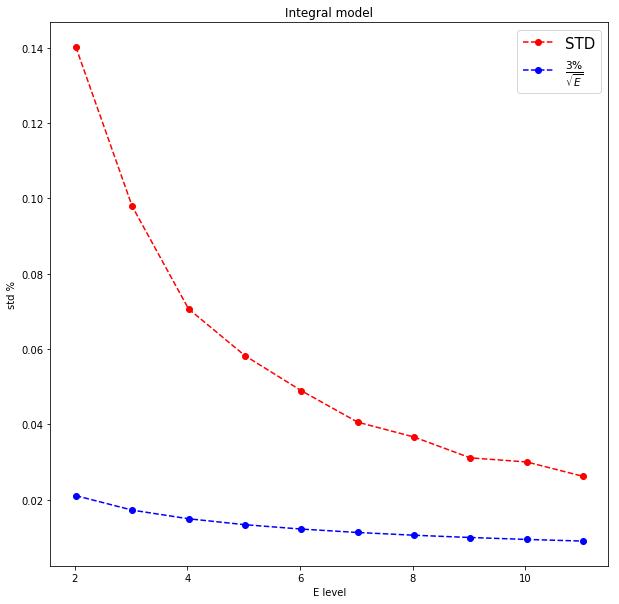

In [1360]:
test_sigmas(model)
plt.title('Integral model')

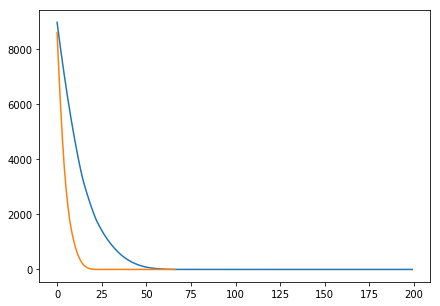

In [1367]:
plt.figure( figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)

In [1187]:
preds.shape

(3200, 1)

In [1192]:
y_test_set = y_test['E'].values
preds = prediction.detach().numpy().reshape((-1))
df = pd.DataFrame({"y_test":y_test_set, "prop": (preds/y_test_set)})

/mnt/vlopatkin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


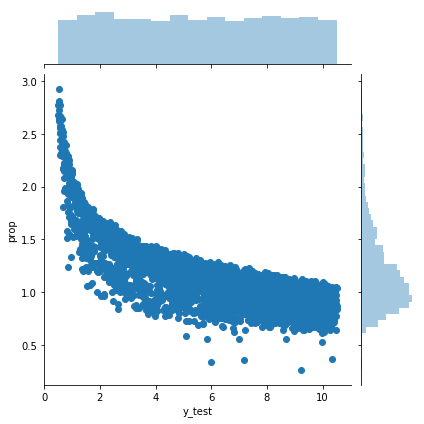

In [1193]:
sns.jointplot(x="y_test", y="prop", data=df)

In [979]:
prediction = model(X_test_tensor)
print('Loss:',compute_loss(y_test_tensor, prediction).item())
print('R2:',r2_score(y_test_tensor.detach().numpy(), prediction_df.values))
# print(scaler.mean_)
prediction_df = pd.DataFrame(prediction.detach().numpy())
# real_prediction_df = scaler.inverse_transform(prediction_df)
# print('Real error:',mean_squared_error(y_test.iloc[:,0], real_prediction_df.iloc[:,0]))
# print(mean_squared_error(y_test.iloc[:,1], real_prediction_df.iloc[:,1]))

Loss: 1.7270293235778809
R2: 0.7798219317036411


In [1164]:
prediction_df

,0
0,2.900078
1,4.071770
2,9.816216
3,4.672379
4,3.827202
5,7.802971
6,7.280159
7,2.634278
8,9.429513
9,4.814415


In [1202]:
mean_squared_error(preds, y_test_set)

1.3621918847590246

R

In [ ]:
R_model = model

In [950]:
prediction = model(X_test_tensor)
print('Loss:',compute_loss(y_test_tensor, prediction).item())
print('R2:',r2_score(y_test_tensor.detach().numpy(), prediction_df.values))
# print(scaler.mean_)
prediction_df = pd.DataFrame(prediction.detach().numpy())

1.7390071153640747


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [924]:
print('E:',r2_score(y_test, real_prediction_df))

E: 0.045267483150530585


In [1358]:
def test_sigmas(model):
    preds = np.maximum(model(X_test_tensor).detach().numpy(), 0)
    
    true_energy = pd.DataFrame({'E':y_test_set})
    true_energy['level'] = true_energy['E'].apply(lambda x: round(x))
    true_energy['pred'] = pd.DataFrame(preds)
    CONST = 1.022
    sigmas = {}
    MSEs = {}
    for energy in range(1,11):
        sub_df = true_energy[true_energy['level'] == energy]
        sigmas[energy] = np.std(abs(sub_df['E'] - sub_df['pred'])) / (energy + CONST)
        MSEs[energy] = mean_squared_error(sub_df['E'],sub_df['pred'])
        
    a = 2.8
    b=0.59
    c=0

    # Plot sigmas
    Evis = np.array([en + 1.022  for en in range(1,11)])
    Perc_sigmas = [sigmas[en] for en in range(1,11)]
    perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
    fig = plt.figure(figsize=(10,10))
    plt.plot(Evis, Perc_sigmas, 'ro--', label='STD')
    plt.plot(Evis, perc_3_sqrt_E, 'bo--', label=r'$\frac{3\%}{\sqrt{E}}$')
    # plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
    plt.ylabel("std %")
    plt.xlabel("E level")
    plt.legend(fontsize=15)

In [1344]:
preds = np.maximum(model_E.predict(X_test), 0)

In [1228]:
preds = np.maximum(E_model_3(X_test_tensor).detach().numpy(), 0)

In [1345]:
true_energy = pd.DataFrame({'E':y_test_set})
true_energy['level'] = true_energy['E'].apply(lambda x: round(x))
true_energy['pred'] = pd.DataFrame(preds)
# true_energy['diff'] = true_energy['E'] - true_energy['pred']

In [1346]:
true_energy.head()

,E,level,pred
0,3.396295,3,6.547821
1,2.853090,3,4.832020
2,8.985971,9,9.674952
3,3.417979,3,5.024974
4,2.631805,3,4.774181


In [1347]:
CONST = 1.022
sigmas = {}
MSEs = {}
for energy in range(1,11):
    sub_df = true_energy[true_energy['level'] == energy]
    sigmas[energy] = np.std(abs(sub_df['E'] - sub_df['pred'])) / (energy + CONST)
    MSEs[energy] = mean_squared_error(sub_df['E'],sub_df['pred'])

In [1348]:
sigmas, MSEs

({1: 0.24114492660307998,
  2: 0.12743008788601556,
  3: 0.08698953281625167,
  4: 0.060582212628304176,
  5: 0.047955204153274596,
  6: 0.04471098507495344,
  7: 0.043543194465201954,
  8: 0.03325584326387764,
  9: 0.04117937020359666,
  10: 0.04543530685623697},
 {1: 12.895203526932395,
  2: 7.248307834892331,
  3: 4.315946508044156,
  4: 2.494016291214846,
  5: 1.4154635139631555,
  6: 0.6591770523169531,
  7: 0.34425441770852144,
  8: 0.2236270953905018,
  9: 0.37809152425016546,
  10: 0.5997915187791109})

Text(0.5, 1.0, 'Catboost')

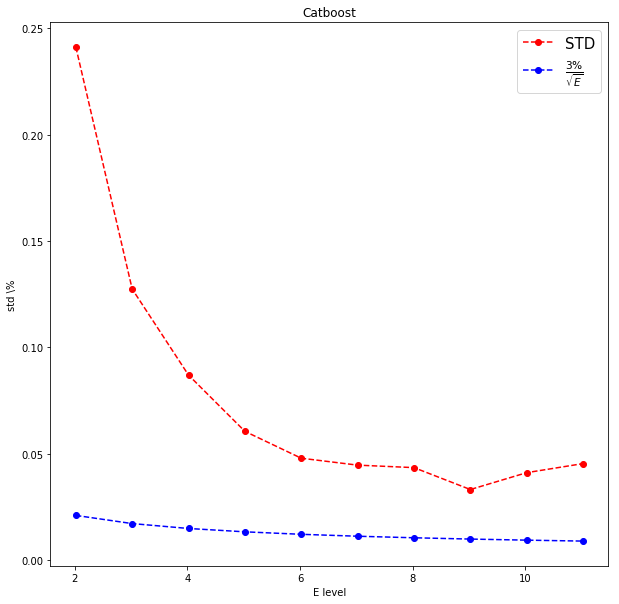

In [1366]:
a = 2.8
b=0.59
c=0

# Plot sigmas
Evis = np.array([en + 1.022  for en in range(1,11)])
Perc_sigmas = [sigmas[en] for en in range(1,11)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
# plt.scatter(Evis, Perc_sigmas, label='STD')
plt.plot(Evis, Perc_sigmas, 'ro--', label='STD')
plt.plot(Evis, perc_3_sqrt_E, 'bo--', label=r'$\frac{3\%}{\sqrt{E}}$')
# plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std \%")
plt.xlabel("E level")
plt.legend(fontsize=15)
plt.title('Catboost')

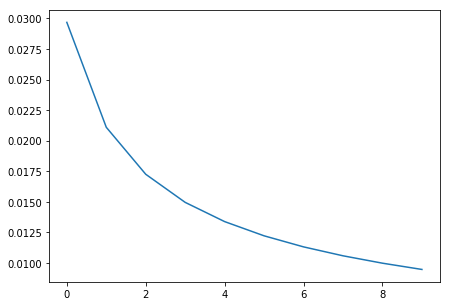

In [883]:
ax = plt.figure(figsize=(7,5))
plt.plot(sigma)
plt.plot(treshold)

In [793]:
torch.save(model, './juno/model_yum')

the_model = torch.load('./juno/model_yum')

In [949]:
the_model = torch.load('./juno/model_yum')

In [741]:
prediction_df.head()

,0
0,10.146852
1,10.229349
2,7.544905
3,5.345156
4,6.865389


In [686]:
real_prediction_df.head()

,0,1
0,9.470795,-2.223401e+06
1,9.299592,-2.171172e+06
2,8.166956,-1.575388e+06
3,7.254718,-1.012473e+06
4,8.052483,-1.199993e+06


In [742]:
y_test.head()

,E
2990,8.994131
13607,9.414703
10421,7.589386
6238,5.784189
6790,5.611799


In [843]:
y_test.shape, prediction.shape

((3200, 1), torch.Size([3200, 1]))

(11.10417277378193, 1740203689822.193)